# Facial-Sensing Smart Glasses for Mobile Monitoring of Digital Biomarkers of Depression

This notebook presents the analysis pipeline developed for the study _Facial-Sensing Smart Glasses for Mobile Monitoring of Digital Biomarkers of Depression_. The analyses focus on evaluating automatic facial configurations in participants diagnosed with depression and healthy controls, as they engaged in a video-viewing task designed to elicit positive, neutral, and negative affective responses.

The analyses include the following components:

- Loading pre-trained model and facial movement features
- Generating predictions
- Data and predictions preprocessing
- Extracting digital biomarkers (frequency, intensity, and duration of facial configurations)
- Validating the Facial Configuration Classification (FCC) model on automatic facial movements
- Investigating group differences in facial expressivity as potential digital biomarkers of depression

In [1]:
# Import necessary packages
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from utils.count import get_grouped_num_expressions
from utils.model import load_model, generate_predictions, filter_predictions
from utils.duration import get_grouped_expressions_duration
from utils.intensity import get_grouped_expression_intensity
from utils.statistics import plot_statistics, set_plot_fonts, print_results

In [2]:
# Define paths
features_path = os.path.join("data", "sample_data.csv")
model_path = "model.pkl"
predictions_path = os.path.join("data", "predictions.csv")
intensities_path = os.path.join("data", "intensities.csv")

## 1. Loading features and generating predictions

**Important:** The provided sample data does not include the complete set of features. To access the full feature dataset and machine learning model, please contact the corresponding author at [borjan.sazdov@emteqlabs.com](mailto:borjan.sazdov@emteqlabs.com).  
<br>
If the full features are not available, you may proceed with the precomputed predictions included in this repository.

In [3]:
# ONLY IF FULL FEATURE SET AND MODEL ARE AVAILABLE
# features_data = pd.read_csv(features_path)
# model = load_model(model_path)
# predictions = generate_predictions(features_data, model)

In [4]:
# LOAD GENREATED PREDICTIONS IF FULL FEATURE SET NOT AVAILABLE
predictions = pd.read_csv(predictions_path)

In [5]:
# Load intensities data
intensities_df = pd.read_csv(intensities_path)

## 2. Preprocessing

This step involves the following preprocessing operations:
- Converting facial configuration class labels from integers to descriptive string names  
- Mapping video segments to their corresponding affective categories (positive, negative, neutral)  
- Assigning participants to either the depressed or control group  
- Filtering predictions to retain relevant facial configuration data
- Preprocessing of intensities dataset

In [6]:
# Map facial configurations
mapping = {1: "Smile", 2: "Frown", 3: "Eyebrow Raise"}
# Map video types
video_types_mapping = {
    f"video_{i}": (
        "neutral"
        if i in {1, 2, 3, 4, 5, 12, 13, 14, 15, 16}
        else "negative" if i in {6, 7, 8, 9, 10, 11} else "positive"
    )
    for i in range(1, 26)
}

In [7]:
# Drop samples where participants are not watching videos
predictions = predictions.dropna(subset="Video").reset_index(drop=True)

In [8]:
# Add video type
predictions["video_type"] = predictions["Video"].map(video_types_mapping)
# Group participants in controlled and depressed group
predictions["Group"] = np.where(
    predictions["Subject"].str.startswith("MOOD_01"),
    "Depressed",
    np.where(
        predictions["Subject"].str.startswith("MOOD_02"),
        "Controlled",
        "Other",
    ),
)

In [9]:
# Filter predictions with less than 2 windows
predictions = filter_predictions(predictions, window_threshold=2)
# Filter short predictions to obtain longer facial configurations
long_predictions = filter_predictions(predictions, window_threshold=10)

In [10]:
# Process intensities dataset
intensities_df["Video"] = intensities_df["Video"].replace("", np.nan)
intensities_df = intensities_df.dropna(subset=["Video"]).reset_index(drop=True)
intensities_df["Group"] = np.where(
    intensities_df["Subject"].str.startswith("MOOD_01"),
    "Depressed",
    np.where(
        intensities_df["Subject"].str.startswith("MOOD_02"),
        "Controlled",
        "Other",
    ),
)
intensities_df["video_type"] = intensities_df["Video"].map(video_types_mapping)

## 3. Model validation on automatic facial movements

This section evaluates the model's performance on automatic facial expressions by analyzing the frequency and intensity of detected facial configurations across different video categories (positive, negative, and neutral).

In [11]:
# Extract facial configuration frequency per video type
count_video_type = get_grouped_num_expressions(
    predictions,
    grouping_columns=["Subject", "video_type"],
    mapping=mapping,
    group_labels=True,
    normalize=True,
    scaler=MinMaxScaler(),
)
# Extract configuration intensity per video type
intensity_video_type = get_grouped_expression_intensity(
    intensities_df,
    grouping_columns=["Subject", "video_type", "Video"],
    mapping=mapping,
    group_labels=True,
)
intensity_video_type = (
    intensity_video_type.groupby(["Subject", "video_type", "label"])[
        "Expression Intensity"
    ].mean()
).reset_index()

['Subject', 'video_type', 'Video']


In [12]:
# Define variables for statistical analysis
labels = mapping.values()
video_types = ["positive", "negative", "neutral"]

pairs = [
    pair
    for vt in video_types
    for pair in itertools.combinations([(vt, label) for label in labels], 2)
]
set_plot_fonts(title=24, legend=18, ticks=20, labels=22)
palette = {
    "Smile": "#ffab7b",
    "Frown": "#a9dea9",
    "Eyebrow Raise": "#ecbcff",
}

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

positive_Frown vs. positive_Smile: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.955e-13 U_stat=8.335e+02
positive_Eyebrow Raise vs. positive_Frown: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:6.762e-01 U_stat=2.414e+03
neutral_Frown vs. neutral_Smile: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.051e-03 U_stat=4.012e+03
neutral_Eyebrow Raise vs. neutral_Frown: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.868e-02 U_stat=2.122e+03
negative_Frown vs. negative_Smile: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.358e-06 U_stat=4.414e+03
negative_Eyebrow Raise vs. negative_Frown: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:4.630e-04 U_stat=

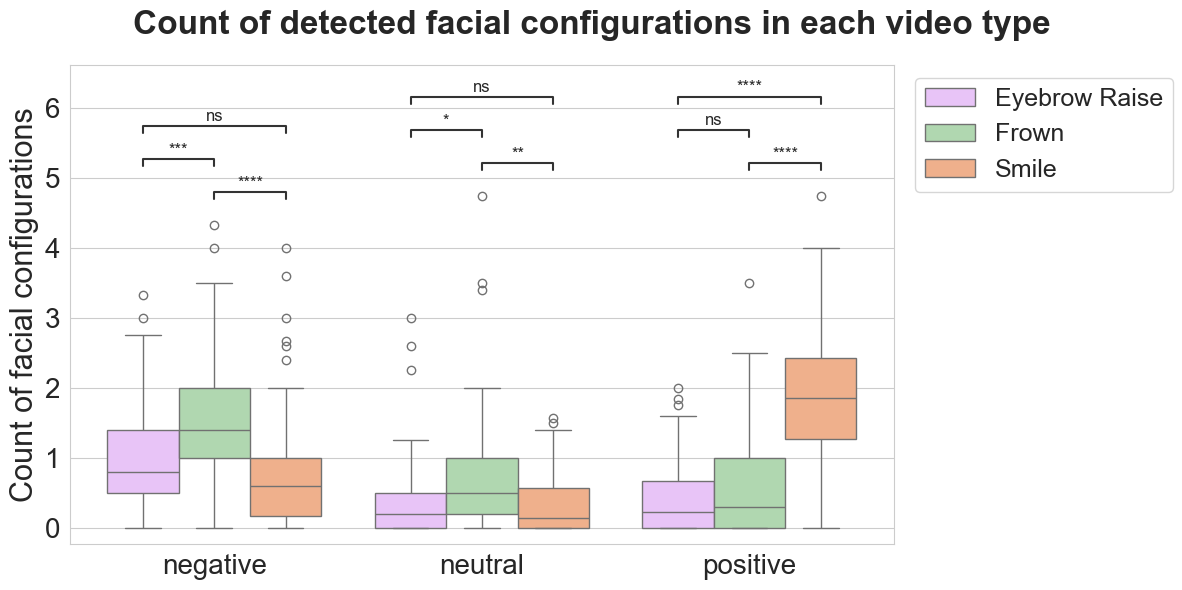


**positive, Frown vs positive, Smile**

| Field                   | Value                                |
|-------------------------|--------------------------------------|
| test_description        | Mann-Whitney-Wilcoxon test two-sided |
| test_short_name         | M.W.W.                               |
| stat_str                | U_stat                               |
| stat_value              | 833.5                                |
| pvalue                  | 2.954863819429336e-13                |
| _corrected_significance | True                                 |
| _correction_method      | Bonferroni                           |
| alpha                   | 0.05                                 |
| group1                  | ('positive', 'Frown')                |
| group2                  | ('positive', 'Smile')                |

**positive, Eyebrow Raise vs positive, Frown**

| Field                   | Value                                |
|-------------------------|------------

In [13]:
sns.set_style("whitegrid")
title = "Count of detected facial configurations in each video type"
results = plot_statistics(
    count_video_type,
    pairs,
    x="video_type",
    y="expression_count",
    hue="label",
    test="Mann-Whitney",
    xlabel="",
    ylabel="Count of facial configurations",
    title=title,
    palette=palette,
    bbox_to_anchor=(1.01, 1),
)
print_results(results)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

positive_Frown vs. positive_Smile: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.929e-06 U_stat=1.316e+03
positive_Eyebrow Raise vs. positive_Frown: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=2.327e+03
neutral_Frown vs. neutral_Smile: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:6.055e-03 U_stat=3.521e+03
neutral_Eyebrow Raise vs. neutral_Frown: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:6.805e-03 U_stat=1.811e+03
negative_Frown vs. negative_Smile: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.771e-05 U_stat=3.839e+03
negative_Eyebrow Raise vs. negative_Frown: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.913e-02 U_stat=

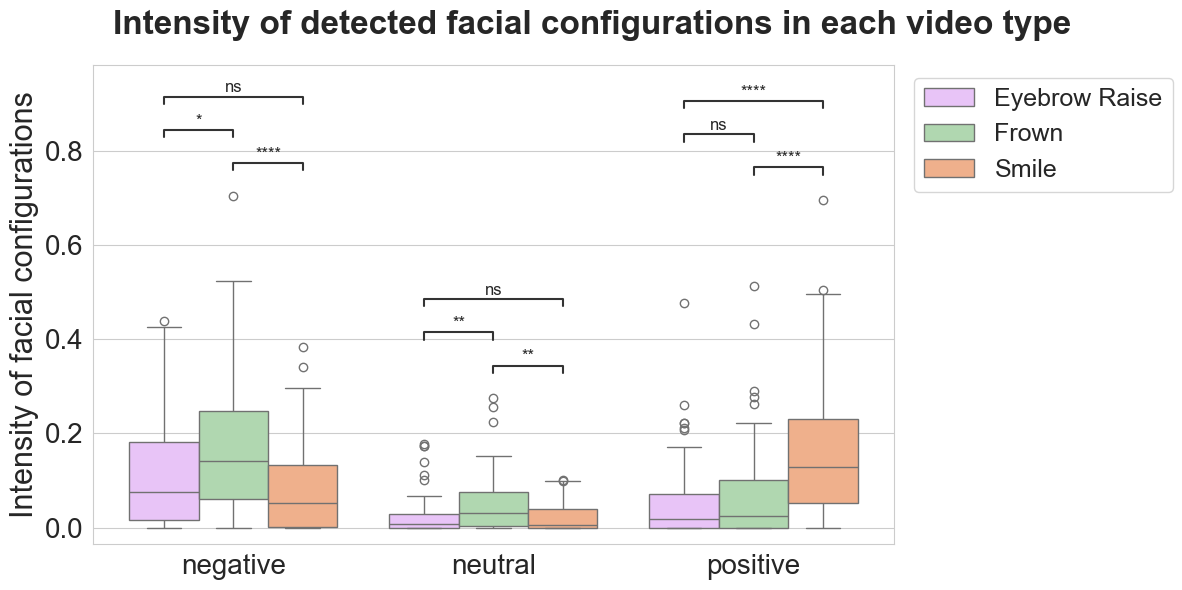


**positive, Frown vs positive, Smile**

| Field                   | Value                                |
|-------------------------|--------------------------------------|
| test_description        | Mann-Whitney-Wilcoxon test two-sided |
| test_short_name         | M.W.W.                               |
| stat_str                | U_stat                               |
| stat_value              | 1316.0                               |
| pvalue                  | 2.928522340568865e-06                |
| _corrected_significance | True                                 |
| _correction_method      | Bonferroni                           |
| alpha                   | 0.05                                 |
| group1                  | ('positive', 'Frown')                |
| group2                  | ('positive', 'Smile')                |

**positive, Eyebrow Raise vs positive, Frown**

| Field                   | Value                                |
|-------------------------|------------

In [14]:
sns.set_style("whitegrid")
set_plot_fonts(title=24, legend=18, ticks=20, labels=22)
title = "Intensity of detected facial configurations in each video type"
results = plot_statistics(
    intensity_video_type,
    pairs,
    x="video_type",
    y="Expression Intensity",
    hue="label",
    test="Mann-Whitney",
    xlabel="",
    ylabel="Intensity of facial configurations",
    title=title,
    palette=palette,
    bbox_to_anchor=(1.01, 1),
)
print_results(results)

## 4. Investigating digital biomarkers for depression

This section examines group differences between control and depressed participants based on the duration, frequency, and intensity of facial configurations.

In [15]:
# Extract facial configuration frequency per group per subject
count_groups = get_grouped_num_expressions(
    long_predictions,
    grouping_columns=["Group", "Subject"],
    mapping=mapping,
    group_labels=False,
    normalize=True,
    scaler=MinMaxScaler(),
)
# Extract facial configuration duration per group per subject
duration_groups = get_grouped_expressions_duration(
    predictions,
    grouping_columns=["Group", "Subject"],
    mapping=mapping,
    average=True,
    group=False,
)
# Extract facial configuration intensity per group per subject
intensity_groups = get_grouped_expression_intensity(
    intensities_df,
    grouping_columns=[
        "Group",
        "Subject",
        "video_type",
        "Video",
    ],
    mapping=mapping,
    group_labels=True,
)
intensity_groups = (
    intensity_groups.groupby(["Group", "Subject", "video_type", "label"])[
        "Expression Intensity"
    ].mean()
).reset_index()
intensity_groups["Expression Intensity"] = (
    intensity_groups["Expression Intensity"] * 100
)

['Group', 'Subject', 'Video']


In [16]:
# Parameters for statistical analysis
# Statistical analysis
pairs = [("Controlled", "Depressed")]
palette = {
    "Controlled": "#6d90ca",  # Blue
    "Depressed": "#ffab7b",  # Orange
}
set_plot_fonts(title=24, legend=18, ticks=20, labels=22)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Controlled vs. Depressed: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.255e-02 U_stat=9.640e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Controlled vs. Depressed: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.874e-02 U_stat=9.550e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


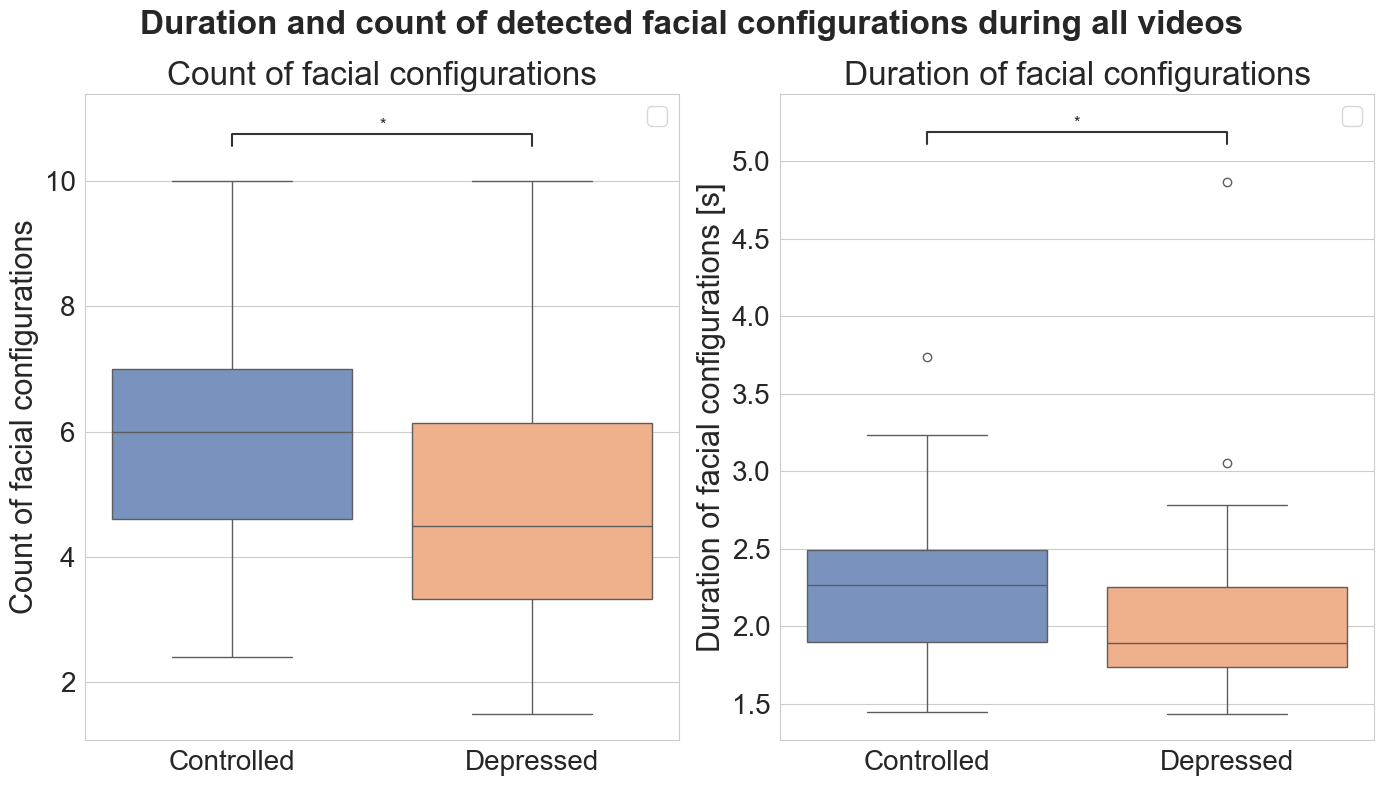


**Controlled vs Depressed**

| Field                   | Value                                |
|-------------------------|--------------------------------------|
| test_description        | Mann-Whitney-Wilcoxon test two-sided |
| test_short_name         | M.W.W.                               |
| stat_str                | U_stat                               |
| stat_value              | 964.0                                |
| pvalue                  | 0.022549646329651396                 |
| _corrected_significance | True                                 |
| _correction_method      | Bonferroni                           |
| alpha                   | 0.05                                 |
| group1                  | ('Controlled',)                      |
| group2                  | ('Depressed',)                       |

**Controlled vs Depressed**

| Field                   | Value                                |
|-------------------------|--------------------------------------|
| 

In [17]:
sns.set_style("whitegrid")
title = "Duration and count of detected facial configurations during all videos"
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
results_duration = plot_statistics(
    count_groups,
    pairs,
    x="Group",
    y="expression_count",
    xlabel="",
    ylabel="Count of facial configurations",
    hue="Group",
    path_to_save=None,
    show_plot=False,
    palette=palette,
    ax=ax[0],
)
ax[0].set_title("Count of facial configurations")
results_count = plot_statistics(
    duration_groups,
    pairs,
    x="Group",
    y="duration",
    xlabel="",
    ylabel="Duration of facial configurations [s]",
    hue="Group",
    title=title,
    path_to_save=None,
    show_plot=False,
    palette=palette,
    ax=ax[1],
)
ax[1].set_title("Duration of facial configurations")
plt.show()
print_results(results_duration)
print_results(results_count)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Frown_Controlled vs. Frown_Depressed: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.489e-02 U_stat=8.940e+02
Eyebrow Raise_Controlled vs. Eyebrow Raise_Depressed: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=6.240e+02
Smile_Controlled vs. Smile_Depressed: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:5.621e-01 U_stat=7.840e+02


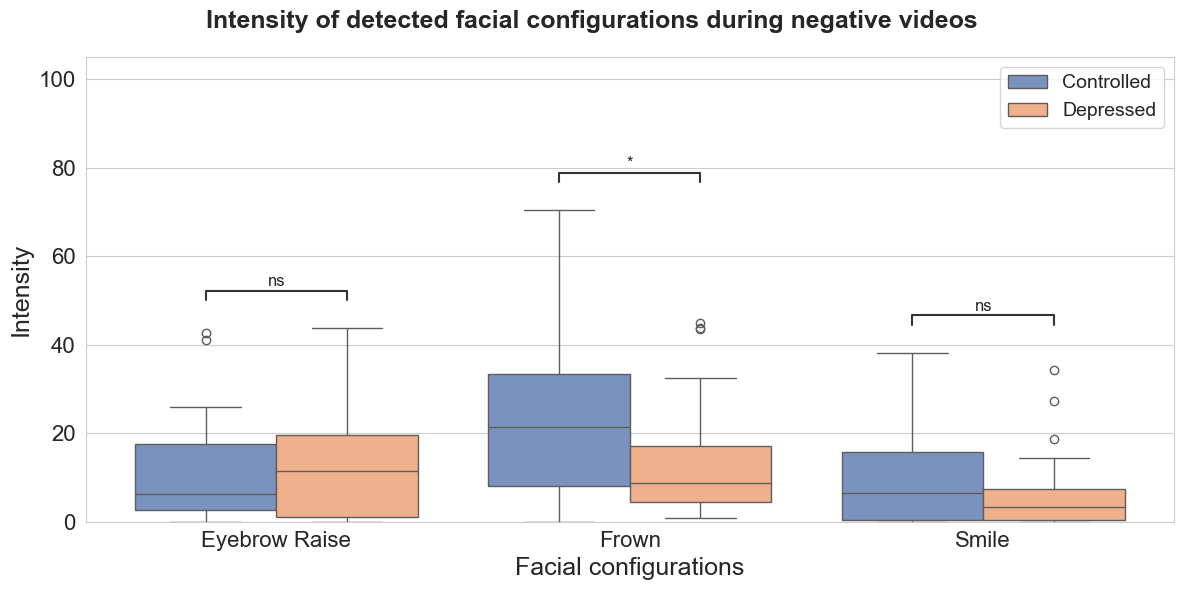


**Frown, Controlled vs Frown, Depressed**

| Field                   | Value                                |
|-------------------------|--------------------------------------|
| test_description        | Mann-Whitney-Wilcoxon test two-sided |
| test_short_name         | M.W.W.                               |
| stat_str                | U_stat                               |
| stat_value              | 894.0                                |
| pvalue                  | 0.03488947582615696                  |
| _corrected_significance | True                                 |
| _correction_method      | Bonferroni                           |
| alpha                   | 0.05                                 |
| group1                  | ('Frown', 'Controlled')              |
| group2                  | ('Frown', 'Depressed')               |

**Eyebrow Raise, Controlled vs Eyebrow Raise, Depressed**

| Field                   | Value                                |
|------------------------

In [18]:
test_data = intensity_groups[intensity_groups["video_type"] == "negative"]
pairs = [
    ((expression, "Controlled"), (expression, "Depressed"))
    for expression in intensity_groups["label"].unique()
]
test_data["Group"].unique()
set_plot_fonts(title=18, legend=14, ticks=16, labels=18)
sns.set_style("whitegrid")
title = "Intensity of detected facial configurations during negative videos"
results_duration = plot_statistics(
    test_data,
    pairs,
    x="label",
    y="Expression Intensity",
    ylabel="Intensity",
    xlabel="Facial configurations",
    hue="Group",
    title=title,
    show_plot=True,
    palette=palette,
    ylim=(0, 105),
)
print_results(results_duration)